<a href="https://colab.research.google.com/github/briantomato/UMDAOSC650/blob/main/FS_650.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# I think some of my programming may be a little sloppy, but if everything run in order will work
# well at least it worked in colab connected to my drive... I may need some help getting it to run
# accessing the data from github

# Import stuff!

%reset
import random
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import pickle
import importlib
import numpy.ma as ma
import time
import datetime
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import keras
from keras import layers
!pip install keras-tuner -q
import keras_tuner
from keras_tuner.tuners import RandomSearch
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

!pip install netCDF4
import netCDF4 as nc
from google.colab import drive
drive.mount('/content/drive')



Once deleted, variables cannot be recovered. Proceed (y/[n])? y
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 690.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
#------------------------------------------------------------
#------------- Open and read in .nc files -------------------
#------------------------------------------------------------

rootdir = "/content/drive/MyDrive/AOSC650_project/"     #project folder where data is
fn = 'onefluxnet_daily_mcd43a_c61.nc'                   #data file name for fluxnet data used for publsihed model
data = nc.Dataset(rootdir+fn)                           #reads in .nc file
fnfsv2pt0 = 'fluxsat_v2_at_onefluxnet_daily_new2.nc'    #FSv2.0 collocated at EC flux towers
fnfsv2pt2 = 'fluxsat_v2.2_at_onefluxnet_daily.nc'       #FSv2.2 collocated at EC flux towers
dataFSv20 = nc.Dataset(rootdir+fnfsv2pt0)
dataFSv22 = nc.Dataset(rootdir+fnfsv2pt2)



In [ ]:
#Make .nc file that contains EC data and MODIS reflectances into a pandas dataframe
df_data = []
df_data  = pd.DataFrame()               #makes empty data frame
for var in data.variables.keys():       #loops through variables in the .nc file
  #print (var)                          #prints the name of the variable
  shp=data[var][:].shape                #the shape of each variable
  #print (shp)                          #prints the shape of each variable
  if len(shp)==1:                       #most variables are a 1d array
    df_data[var]=data[var][:]           #appends columns to data frame
  if len(shp)==2:                       #the MODIS data variables are a 2d array for bands 1-7  MCD43 is at 1km spatial res and MCD43a is at 500m spatial res
    print(var)
    var_data = data[var][:]             #gets the data from the .nc variable
    numpy_array = np.array(var_data)    #makes the data into a numpy array
    band_num = 0                        #counter for band number
    for column in numpy_array.T:        #loops through bands in the numpy array
      band_num = band_num+1             #increase band number counter
      hdr_str = var + '_B' + str(band_num)        #create header name for dataframe
      new_df  = pd.DataFrame({hdr_str: column})       #creats new dataframe with header and column of data
      df_data = pd.concat([df_data, new_df], axis=1)  #appends MODIS reflectance for each band to dataframe

df_data = df_data.astype({'Year':'int64', 'Month':'int64', 'Day':'int64'})
df_data['Combined'] = df_data['Year']*1000 + df_data['Day']                     #Make a header for date in datetime
df_data['Date'] = pd.to_datetime(df_data['Combined'], format = "%Y%j")
df_data['Day'] = df_data['Date'].dt.day
df_data['Month'] = df_data['Date'].dt.month
df_data['Year'] = df_data['Date'].dt.year
df_data = df_data.drop('Combined', axis=1)

df_data=df_data.sort_values(by=['Name','Date'])

MCD43
MCD43a


In [ ]:
# Reading in FSv2.0 and FSv2.2 GPP to dataframe since in this project I want to see
# if I can improve on previously modeled GPP. Will be used to assess/evaluate/basis of comparison

#creates data frame for FSv2.0 with just Name GPP and Datetime
df_dataFSv20 = []
df_dataFSv20  = pd.DataFrame()               #makes empty data frame
for var in dataFSv20.variables.keys():       #loops through variables in the .nc file
  df_dataFSv20[var]=dataFSv20[var][:]           #appends columns to data frame

df_dataFSv20 = df_dataFSv20.astype({'Year':'int64', 'Month':'int64', 'Day':'int64'})
df_dataFSv20['Date'] = pd.to_datetime(df_dataFSv20[['Year', 'Month', 'Day']])
col_to_drop = ['Year','Month','Day','GPP_uncertainty','BRDF_qual','Percent_inputs']
df_dataFSv20.drop(columns=col_to_drop, inplace=True)  #drop data columns I'm not using
df_dataFSv20.rename(columns={'GPP': 'GPP FSv2.0'}, inplace=True) #rename GPP so has unique header in larger df

#creates data frame for FSv2.2 with just Name GPP and Datetime
df_dataFSv22 = []
df_dataFSv22  = pd.DataFrame()               #makes empty data frame
for var in dataFSv22.variables.keys():       #loops through variables in the .nc file
  df_dataFSv22[var]=dataFSv22[var][:]           #appends columns to data frame

df_dataFSv22 = df_dataFSv22.astype({'Year':'int64', 'Month':'int64', 'Day':'int64'})
df_dataFSv22['Date'] = pd.to_datetime(df_dataFSv22[['Year', 'Month', 'Day']])
df_dataFSv22.drop(columns=col_to_drop, inplace=True)  #drop data columns I'm not using
df_dataFSv22.rename(columns={'GPP': 'GPP FSv2.2'}, inplace=True) #rename GPP so has unique header in larger df

print('done')
#pd.set_option('display.max_columns', None)
#display(df_dataFSv22.head(5))

done


In [ ]:
#Merge FSv2.0 and v2.2 GPP to dataframe with EC fluxes and MODIS reflectances
df_data = pd.merge(df_data,df_dataFSv20, on=['Date', 'Name'], how='left')
df_data = pd.merge(df_data,df_dataFSv22, on=['Date', 'Name'], how='left')
pd.set_option('display.max_columns', None)
display(df_data.head(5))

,Year,Month,Day,Name,Type,Latitude,Longitude,NEE_VUT_REF,NEE_VUT_REF_RANDUNC,NEE_VUT_REF_QC,RECO_NT_VUT_REF,RECO_DT_VUT_REF,GPP_NT_VUT_REF,GPP_DT_VUT_REF,TA_F,TA_F_QC,VPD_F,VPD_F_QC,SW_IN_F,SW_IN_F_QC,SW_IN_POT,SW_DIF,PAR_clr,MCD43_B1,MCD43_B2,MCD43_B3,MCD43_B4,MCD43_B5,MCD43_B6,MCD43_B7,MCD43a_B1,MCD43a_B2,MCD43a_B3,MCD43a_B4,MCD43a_B5,MCD43a_B6,MCD43a_B7,Date,GPP FSv2.0,GPP FSv2.2
0,2009,12,14,AR-SLu,MF,-33.464802,-66.459801,-6.02047,0.367174,0.208333,3.48171,11.0958,15.7682,15.2704,24.921000,0.354167,17.489000,0.354167,402.239014,0.4375,515.046997,NaN,0.361655,0.079,0.223,0.042,0.073,0.279,0.250,0.164,0.0825,0.2287,0.0453,0.0767,0.2785,0.2557,0.1674,2009-12-14,3.207074,4.226634
1,2009,12,14,AR-SLu,MF,-33.464802,-66.459801,-6.02047,0.367174,0.208333,3.48171,11.0958,15.7682,15.2704,24.921000,0.354167,17.489000,0.354167,402.239014,0.4375,515.046997,NaN,0.361655,0.079,0.223,0.042,0.073,0.279,0.250,0.164,0.0825,0.2287,0.0453,0.0767,0.2785,0.2557,0.1674,2009-12-14,3.207074,4.226634
2,2009,12,15,AR-SLu,MF,-33.464802,-66.459801,-5.92102,0.378315,0.395833,3.74684,11.3064,11.9188,11.2756,26.837000,0.395833,17.812000,0.395833,198.251999,0.4375,515.452026,NaN,0.361865,0.079,0.222,0.042,0.073,0.277,0.246,0.163,0.0841,0.2255,0.0464,0.0776,0.2730,0.2497,0.1677,2009-12-15,3.106837,4.242608
3,2009,12,16,AR-SLu,MF,-33.464802,-66.459801,-5.91296,0.381048,0.395833,3.63799,11.2280,12.8748,12.3111,26.077999,0.395833,10.786000,0.395833,251.397995,0.4375,515.812988,NaN,0.362049,0.077,0.221,0.041,0.072,0.276,0.242,0.160,0.0819,0.2242,0.0450,0.0759,0.2728,0.2436,0.1640,2009-12-16,3.128879,4.246148
4,2009,12,17,AR-SLu,MF,-33.464802,-66.459801,-5.89824,0.387895,0.395833,4.04771,11.5171,13.9086,13.3462,28.917000,0.395833,16.771999,0.395833,290.625000,0.4375,516.132019,NaN,0.362207,0.077,0.221,0.041,0.072,0.275,0.242,0.160,0.0816,0.2237,0.0448,0.0755,0.2723,0.2430,0.1636,2009-12-17,3.136784,4.249453


In [ ]:
#Filter out NaN, -999s and other fill or no data values, and quality control filtering
df_copy=[]
df_copy=df_data

#headers_to_drop_nans = ['NEE_VUT_REF_QC','NEE_VUT_REF_RANDUNC','GPP_DT_VUT_REF', 'GPP_NT_VUT_REF','TA_F','VPD_F']     #array of headers to drop NaNs
headers_to_drop_nans = ['NEE_VUT_REF_QC','NEE_VUT_REF_RANDUNC','GPP_DT_VUT_REF', 'GPP_NT_VUT_REF']                     #array of headers to drop NaNs
df_copy = df_copy.dropna(subset=headers_to_drop_nans)                                                                  #Drop NaNs for specified header variables
df_copy = df_copy[df_copy['GPP_NT_VUT_REF'] >= -5]                                                                     #filter out data where the nighttime gpp is less than -5
df_copy = df_copy[abs(df_copy['GPP_NT_VUT_REF']-df_copy['GPP_DT_VUT_REF']) <= 3]                                       #Filter out rows where the absolute difference between the nighttime and daytime retrieval of GPP is greater than 3
df_copy = df_copy[df_copy['NEE_VUT_REF_RANDUNC'] <= 3]                                                                 #Filter out rows where the NEE_VUT_REF_RANDUNC is above 3
df_copy = df_copy[df_copy['NEE_VUT_REF_QC'] >= 0.8]                                                                    #Filter out rows where the NEE_VUT_REF_QC (quality control) is below 0.8
df_copy = df_copy[df_copy['MCD43_B1'] > 0]                                                                             #filter out -999 and negatives values for Bands
df_copy = df_copy[df_copy['MCD43_B2'] > 0]
df_copy = df_copy[df_copy['MCD43_B3'] > 0]
df_copy = df_copy[df_copy['MCD43_B4'] > 0]
df_copy = df_copy[df_copy['MCD43_B5'] > 0]
df_copy = df_copy[df_copy['MCD43_B6'] > 0]
df_copy = df_copy[df_copy['MCD43_B7'] > 0]
df_copy = df_copy[df_copy['MCD43a_B1'] > 0]
df_copy = df_copy[df_copy['MCD43a_B2'] > 0]
df_copy = df_copy[df_copy['MCD43a_B3'] > 0]
df_copy = df_copy[df_copy['MCD43a_B4'] > 0]
df_copy = df_copy[df_copy['MCD43a_B5'] > 0]
df_copy = df_copy[df_copy['MCD43a_B6'] > 0]
df_copy = df_copy[df_copy['MCD43a_B7'] > 0]
df_copy = df_copy[df_copy['GPP FSv2.0'] > 0]
df_copy = df_copy[df_copy['GPP FSv2.2'] > 0]

df_copy['GPP'] = df_copy[['GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].mean(axis=1) #Use the average of daytime and nightime GPP as my GPP label
df_copy = df_copy.reset_index(drop=True)  #resent index after removing so many rows.
pd.set_option('display.max_columns', None)
#display(df_copy.head(10))
display(df_copy.head())




,Year,Month,Day,Name,Type,Latitude,Longitude,NEE_VUT_REF,NEE_VUT_REF_RANDUNC,NEE_VUT_REF_QC,RECO_NT_VUT_REF,RECO_DT_VUT_REF,GPP_NT_VUT_REF,GPP_DT_VUT_REF,TA_F,TA_F_QC,VPD_F,VPD_F_QC,SW_IN_F,SW_IN_F_QC,SW_IN_POT,SW_DIF,PAR_clr,MCD43_B1,MCD43_B2,MCD43_B3,MCD43_B4,MCD43_B5,MCD43_B6,MCD43_B7,MCD43a_B1,MCD43a_B2,MCD43a_B3,MCD43a_B4,MCD43a_B5,MCD43a_B6,MCD43a_B7,Date,GPP FSv2.0,GPP FSv2.2,GPP
0,2009,12,21,AR-SLu,MF,-33.464802,-66.459801,-6.20090,0.382884,0.916667,4.09222,11.6078,14.8904,14.6503,29.247999,0.9375,24.445999,0.937500,343.346008,0.708333,516.968994,NaN,0.362574,0.081,0.235,0.044,0.076,0.287,0.252,0.158,0.0834,0.2336,0.0466,0.0782,0.2861,0.2477,0.1591,2009-12-21,5.068244,4.779741,14.770350
1,2009,12,22,AR-SLu,MF,-33.464802,-66.459801,-5.61956,0.372080,0.937500,3.95545,11.8719,14.1744,14.3019,30.527000,1.0000,23.583000,1.000000,324.569000,0.812500,517.068970,NaN,0.362601,0.079,0.237,0.043,0.076,0.289,0.252,0.156,0.0817,0.2362,0.0457,0.0776,0.2883,0.2482,0.1581,2009-12-22,5.117513,4.775973,14.238150
2,2009,12,23,AR-SLu,MF,-33.464802,-66.459801,-4.28703,0.334310,0.812500,3.31299,11.6788,11.1678,11.3725,28.902000,1.0000,16.900999,0.979167,220.972000,0.666667,517.125000,NaN,0.362601,0.080,0.240,0.043,0.076,0.291,0.255,0.156,0.0819,0.2398,0.0457,0.0781,0.2927,0.2505,0.1566,2009-12-23,5.025277,4.977170,11.270150
3,2009,12,24,AR-SLu,MF,-33.464802,-66.459801,-6.30522,0.443418,1.000000,2.85094,11.1704,14.0823,14.6363,25.225000,1.0000,11.938000,1.000000,333.109009,0.854167,517.137024,NaN,0.362574,0.080,0.240,0.043,0.075,0.291,0.256,0.155,0.0816,0.2400,0.0456,0.0778,0.2933,0.2528,0.1559,2009-12-24,5.130382,5.044286,14.359301
4,2009,12,25,AR-SLu,MF,-33.464802,-66.459801,-3.96959,0.401757,0.833333,3.39763,10.3867,13.9436,14.0756,28.948000,1.0000,18.299999,1.000000,335.119995,0.770833,517.104980,NaN,0.362522,0.075,0.230,0.040,0.071,0.279,0.241,0.151,0.0744,0.2290,0.0402,0.0711,0.2831,0.2339,0.1507,2009-12-25,5.025183,4.982818,14.009600


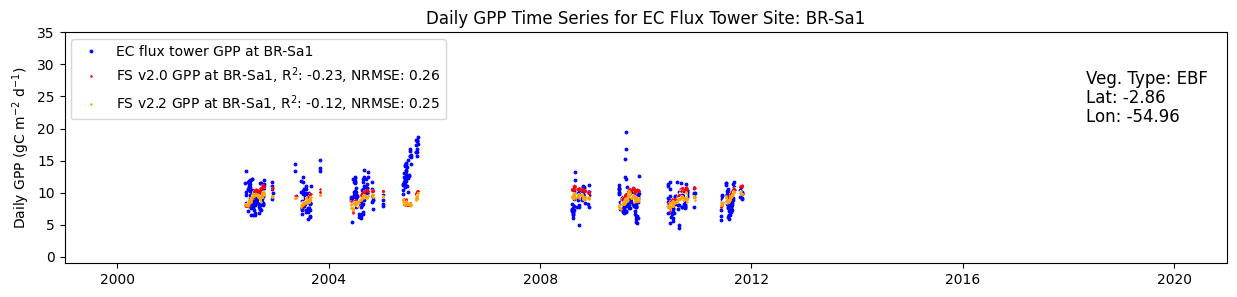

In [ ]:
#Plot a single site
# I should've made this plotting a function
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
unique_name = 'BR-Sa1'  #I used BR-Sa1, CA-TP4, DE-Geb, US-DK3
fig, ax = plt.subplots(figsize=(15,3))
filtered_df = df_copy[df_copy['Name'] == unique_name]
r2FSv20 = r2_score(filtered_df['GPP'].values,filtered_df['GPP FSv2.0'].values)
r2FSv22 = r2_score(filtered_df['GPP'].values,filtered_df['GPP FSv2.2'].values)
rmseFSv20 = np.sqrt(mean_squared_error(filtered_df['GPP'].values,filtered_df['GPP FSv2.0'].values))
rmseFSv22 = np.sqrt(mean_squared_error(filtered_df['GPP'].values,filtered_df['GPP FSv2.2'].values))
meanGPP = filtered_df['GPP'].mean()
nrmseFSv20 = rmseFSv20/meanGPP
nrmseFSv22 = rmseFSv22/meanGPP
sns.lineplot(x = 'Date', y = 'GPP',data = filtered_df, marker='o', color='white', markerfacecolor='blue', markeredgecolor='blue', markersize=2, label='EC flux tower GPP at ' + unique_name)
sns.lineplot(x = 'Date', y = 'GPP FSv2.0',data = filtered_df, marker='o', color='white', markerfacecolor='red', markeredgecolor='red', markersize=1, label='FS v2.0 GPP at ' + unique_name + ', R$\mathregular{^{2}}$: ' + str(format(r2FSv20, ".2f")) + ', NRMSE: ' + str(format(nrmseFSv20, ".2f")))
sns.lineplot(x = 'Date', y = 'GPP FSv2.2',data = filtered_df, marker='o', color='white', markerfacecolor='orange', markeredgecolor='orange', markersize=1, label='FS v2.2 GPP at ' + unique_name + ', R$\mathregular{^{2}}$: ' + str(format(r2FSv22, ".2f")) + ', NRMSE: ' + str(format(nrmseFSv22, ".2f")))
ylim = [-1, 35]
ax.set_ylim(ylim)
ax.set_xlim([datetime.date(1999, 1, 1), datetime.date(2020, 12, 31)])
lat = filtered_df.iloc[0]['Latitude']
lon = filtered_df.iloc[0]['Longitude']
veg = filtered_df.iloc[0]['Type']
ax.text(datetime.date(2018, 5, 1), 27, 'Veg. Type: ' + veg, fontsize=12, color='black')
ax.text(datetime.date(2018, 5, 1), 24, 'Lat: ' + str(format(lat, ".2f")), fontsize=12, color='black')
ax.text(datetime.date(2018, 5, 1), 21, 'Lon: ' + str(format(lon, ".2f")), fontsize=12, color='black')
plt.title(f"Daily GPP Time Series for EC Flux Tower Site: {unique_name}")
plt.xlabel('')
ax.set_ylabel(r'Daily GPP (gC m$\mathregular{^{-2}}$ d$\mathregular{^{-1}}$)',
               fontsize=10)

plt.legend(loc='upper left')
plt.show()

In [ ]:
#define density scatter plot function for evaluation
def scatter_plot(ytrue, ypred, modelV):

    R2 = sklearn.metrics.r2_score(ytrue, ypred)
    MAE = sklearn.metrics.mean_absolute_error(ytrue, ypred)
    coefficients = np.polyfit(ytrue, ypred, 1)
    slope, intercept = coefficients

    bin = [0.25 * i for i in range(0, 121)]
    g = sns.histplot(x = ytrue, y = ypred, bins = bin, cbar=True, vmax=250, cmap='inferno')
    plt.plot([0, 30], [0, 30], color='red', linestyle='--',linewidth=1)
    ybin=np.array(bin)*slope+intercept
    plt.plot(bin, ybin, color='blue', linestyle='-',linewidth=2)
    ax.set_xlim(0,30)
    ax.set_ylim(0,30)

    plt.xlabel('EC Flux Tower GPP (gC m$\mathregular{^{-2}}$ d$\mathregular{^{-1}}$)')
    plt.ylabel(modelV +' Predicted GPP (gC m$\mathregular{^{-2}}$ d$\mathregular{^{-1}}$)')
    plt.grid(False)

    scores = (r'R^2 = {:.2f}' + '\n' + r'MAE = {:.2f}').format(
        R2, MAE)
    line = ('y = m' + str(format(slope, ".2f")) + ' + ' + str(format(intercept, ".2f")))
    plt.title(f"{modelV} Predicted GPP")
    plt.text(0, 30, scores, bbox=dict(facecolor = 'white', edgecolor = 'gray', boxstyle = 'round, pad=0.1'),
            fontsize = 10, ha='left', va = 'top')
    plt.text(0, 26, line, bbox=dict(facecolor = 'white', edgecolor = 'gray', boxstyle = 'round, pad=0.1'),
            fontsize = 10, ha='left', va = 'top',color='blue')

    g.collections[0].colorbar.set_label('Counts')

    plt.show()


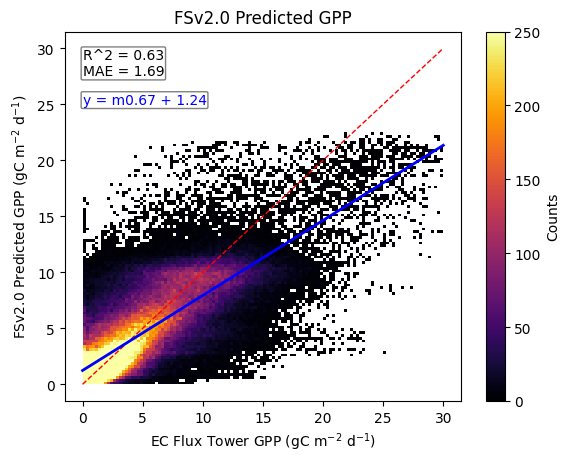

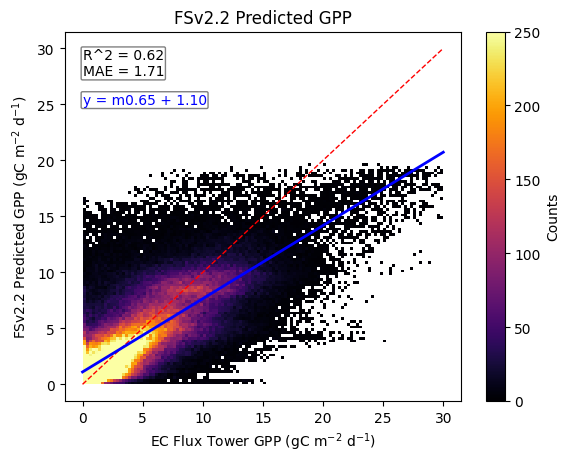

In [ ]:
#Show density scatter plots for EC Flux Tower GPP and FS model predicted GPP
GPP_EC_flux = df_copy['GPP'].values
GPP_FSv20 = df_copy['GPP FSv2.0'].values
GPP_FSv22 = df_copy['GPP FSv2.2'].values
scatter_plot(GPP_EC_flux,GPP_FSv20,'FSv2.0')
scatter_plot(GPP_EC_flux,GPP_FSv22,'FSv2.2')

In [ ]:
#going to follow along with method to select hyper parameters using the keras_tuner_ann_sample.ipynb notebook

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
X=[]
y=[]
df_feature=[]
features = ['Name','GPP', 'PAR_clr','MCD43_B1','MCD43_B2','MCD43_B3','MCD43_B4','MCD43_B5','MCD43_B6','MCD43_B7'] #features to use for NN
df_features = df_copy[features]
input = ['PAR_clr','MCD43_B1','MCD43_B2','MCD43_B3','MCD43_B4','MCD43_B5','MCD43_B6','MCD43_B7'] #input features

#"shrinking" my dataset her so I can more quickly determine hyperparameters to use
#using keras tuner. Ideally I'd use the whole dataset once I'm happy how the tuner is set up.
df_copy_small = df_copy.sample(frac=0.05, random_state=11)

X = df_copy_small[input].values #input
y = df_copy_small['GPP'].values #label

#print(X.shape)
#print(y.shape)

# create our scaler object
scaler_input = MinMaxScaler() #tried MinMaxScaler and did not like, StandardScaler was worse
scaler_targt = MinMaxScaler() #PowerTransformer was even worse!!!
# fit it to our training set
scaler_input.fit(X)
scaler_targt.fit(np.reshape(y, (-1,1)))
# now transform our input data and labels
input_train_scaled = scaler_input.transform(X)
label_train_scaled = scaler_targt.fit_transform(np.reshape(y, (-1,1)))
#y=np.reshape(y, (-1,1))

#print(y)
#print(label_train_scaled)
#I could not figure out how to "unscale" my predicted data quickly, which got put to the end of a "to do" list
#so I am just using the actual values for my predicted label
#I know this is not best practice.
#NEVERMIND ABOVE I FIGURED IT OUT... i think

X_train, X_test, y_train, y_test = train_test_split(input_train_scaled, label_train_scaled, test_size=0.25, random_state=11)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(11933, 8)
(3978, 8)
(11933, 1)
(3978, 1)


In [ ]:
#try to define my own loss function to minimize negative r2
#TBH I asked chatgpt how to do this and I'm shocked it was functional, but I am not going to use it since MAE seemed to work best

import tensorflow as tf
def r_squared(y_true, y_pred):
  y_true_mean = tf.reduce_mean(y_true)
  total_sum_of_squares = tf.reduce_sum(tf.square(y_true - y_true_mean))
  residual_sum_of_squares = tf.reduce_sum(tf.square(y_true - y_pred))
  r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
  return r2

# Define the negative R-squared as a loss function
def negative_r_squared(y_true, y_pred):
  return -r_squared(y_true, y_pred)

from keras.losses import Loss
class NegativeRSquaredLoss(Loss):
    def __init__(self):
        super().__init__()

    def call(self, y_true, y_pred):
        return negative_r_squared(y_true, y_pred)

In [ ]:

#define model to use in keras tuner with set number of layers

from keras.layers import Dense, Dropout

def build_model(hp):
    # start building model
    model = keras.Sequential()

    # input layer stays the same as before
    model.add(keras.Input(shape=(8,), name="input_layer"))

    # instead of choosing the number of nodes, we add an hp object
    hp_units_1 = hp.Int('units_1', min_value=2, max_value=32, step=2)
    hp_units_2 = hp.Int('units_2', min_value=2, max_value=32, step=2)

    #1st hidden layer, also learning activation function, and dropout rate
    model.add(
        keras.layers.Dense(
            units=hp_units_1,
            #activation=keras.activations.softsign #softsign
            #did not have to write a separate function for this when using the .Sequential() method with hp.Choice
            activation=hp.Choice("activation_1", ["relu", "tanh","selu","sigmoid","relu6","silu","gelu","softsign","sigmoid","linear","softmax"]),
            )
        )
    #testing dropout... I don't want to overfit my model because eventually it will be globally upscaled
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.0, max_value=0.5, step=0.1)))
    #model.add(layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5)))
    #2nd hidden layer, also learning activation function, and dropout rate
    model.add(
        keras.layers.Dense(
            units=hp_units_2,
            #activation=keras.activations.sigmoid #sigmoid
            activation=hp.Choice("activation_2", ["relu", "tanh","selu","sigmoid","relu6","silu","gelu","softsign","sigmoid","linear","softmax"]),
            )
        )
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)))
    #output layer, also learning activation function, and dropout rate
    model.add(
        keras.layers.Dense(
            1,
            #activation='linear'
            activation=hp.Choice("activation_output", ["relu", "tanh","selu","sigmoid","relu6","silu","gelu","softsign","sigmoid","linear","softmax"]),
            )
        )
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_rate_output', min_value=0.0, max_value=0.5, step=0.1)))
    # likewise, we will search for the learning rate
    learning_rate = hp.Float(
        "lr", min_value=1e-4, max_value=1e-2, sampling="log"
        )
    model.compile(
        keras.optimizers.Adam(learning_rate=learning_rate),
        #loss=NegativeRSquaredLoss()
        loss='mae'    #settling on MAE since it seemed to give best results
        #loss='mse'
        #loss=tf.keras.losses.Huber(delta=0.5)
        #loss=tf.keras.losses.MeanSquaredLogarithmicError(reduction="sum_over_batch_size", name="mean_squared_logarithmic_error")
        )
    return model


In [ ]:
#this worked... but I don't know if I trust how well it did or if its working as intended
#I gave up on this before including all my hyperparameter searches included above
"""
#define model to use in keras tuner with changing number of layers
from keras.layers import Dense, Dropout
def build_model(hp):
    # start building model
    model = keras.Sequential()

    # input layer stays the same as before
    model.add(keras.Input(shape=(8,), name="input_layer"))

    # instead of choosing the number of nodes, we add an hp object, also for num layers, activation function, and drop out rate
    for i in range(hp.Int("num_layers", 1, 3)):
      model.add(
        keras.layers.Dense(
              # Tune number of units separately.
              units=hp.Int(f"units_{i+1}", min_value=2, max_value=32, step=2),
              activation=hp.Choice(f"activation_{i+1}", ["relu", "tanh","selu","sigmoid","relu6","silu","gelu","softsign","sigmoid","linear","softmax"]),
          )
      )
      model.add(keras.layers.Dropout(rate=hp.Float(f"dropout_rate_{i+1}", min_value=0.0, max_value=0.5, step=0.1)))


    #output layer
    model.add(
        keras.layers.Dense(
            1,
            activation=hp.Choice("activation_output", ["relu", "tanh","selu","sigmoid","relu6","silu","gelu","softsign","sigmoid","linear","softmax"]),
            )
        )
    model.add(keras.layers.Dropout(rate=hp.Float('dropout_rate_output', min_value=0.0, max_value=0.5, step=0.1)))

    # likewise, we will search for the learning rate
    learning_rate = hp.Float(
        "lr", min_value=1e-4, max_value=1e-2, sampling="log"
        )
    model.compile(
        keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mae'
        )
    return model
    """

In [ ]:
build_model(keras_tuner.HyperParameters())

In [ ]:

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_loss",direction="min"),
    max_trials=50,
    #num_initial_points=1000, #"If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used."
    alpha=0.0001, #Float, the value added to the diagonal of the kernel matrix during fitting. It represents the expected amount of noise in the observed performances in Bayesian optimization. Defaults to 1e-4.
    beta=2.6*2, #Float, the balancing factor of exploration and exploitation. The larger it is, the more explorative it is. Defaults to 2.6.
    seed=123,
    # hyperparameters=None, #Optional HyperParameters instance. Can be used to override (or register in advance) hyperparameters in the search space.
    tune_new_entries=True,  #Boolean, whether hyperparameter entries that are requested by the hypermodel but that were not specified in hyperparameters should be added to the search space, or not. If not, then the default value for these parameters will be used. Defaults to True.
    allow_new_entries=True, #Boolean, whether the hypermodel is allowed to request hyperparameter entries not listed in hyperparameters. Defaults to True.
    max_retries_per_trial=0,  #Integer. Defaults to 0. The maximum number of times to retry a Trial if the trial crashed or the results are invalid.
    max_consecutive_failed_trials=3,  #Integer. Defaults to 3. The maximum number of consecutive failed Trials. When this number is reached, the search will be stopped. A Trial is marked as failed when none of the retries succeeded.
    overwrite=True
)

In [ ]:
#show tuner search parameters and options
tuner.search_space_summary()

Search space summary
Default search space size: 9
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 2, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 2, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu', 'softsign', 'sigmoid', 'linear', 'softmax'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu', 'softsign', 'sigmoid', 'linear', 'softmax'], 'ordered': False}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
activation_output (Choice)
{'default': 'relu', 'conditions': [], 'values

In [ ]:
#I'd like to include cross validation in the tuner search
#from sklearn.model_selection import StratifiedKFold
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_data=(
        X_test,
        y_test)#,
    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    #folds=kf
    )
#EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Trial 50 Complete [00h 00m 24s]
val_loss: 0.0892629399895668

Best val_loss So Far: 0.05282082408666611
Total elapsed time: 00h 19m 40s


In [ ]:
#list best models
models = tuner.get_best_models(num_models=5)
models

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                198       
                                                                 
 dropout (Dropout)           (None, 22)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                460       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
 dropout_2 (Dropout)         (None, 1)                 0         
                                                                 
Total params: 679 (2.65 KB)
Trainable params: 679 (2.65 

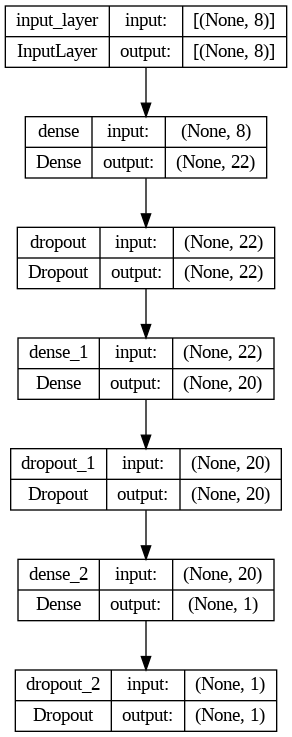

In [ ]:
# here is the best model
import tensorflow as tf

best_model = models[0]
best_model.summary()
tf.keras.utils.plot_model(best_model,to_file='simple.png',show_shapes=True)

In [ ]:

#best activation functions
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_activation_1 = best_hps.get('activation_1')
best_activation_2 = best_hps.get('activation_2')
best_activation_output = best_hps.get('activation_output')
print("Best activation functions for each layer:", best_activation_1, best_activation_2, best_activation_output)


Best activation functions for each layer: selu relu softsign


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 21 summary
Hyperparameters:
units_1: 22
units_2: 20
activation_1: selu
dropout_rate_1: 0.2
activation_2: relu
dropout_rate_2: 0.2
activation_output: softsign
dropout_rate_output: 0.0
lr: 0.0007781436518320102
Score: 0.05282082408666611

Trial 31 summary
Hyperparameters:
units_1: 24
units_2: 32
activation_1: relu
dropout_rate_1: 0.0
activation_2: relu
dropout_rate_2: 0.4
activation_output: relu
dropout_rate_output: 0.0
lr: 0.00026953552492794063
Score: 0.05284963920712471

Trial 16 summary
Hyperparameters:
units_1: 8
units_2: 26
activation_1: relu
dropout_rate_1: 0.4
activation_2: silu
dropout_rate_2: 0.4
activation_output: selu
dropout_rate_output: 0.0
lr: 0.00330588674286921
Score: 0.053217582404613495

Trial 01 summary
Hyperparameters:
units_1: 14
units_2: 16
activation_1: silu
dropout_rate_1: 0.30000000000000004
activation_2: gelu
dropout_rate_2: 0.0
activation_out

In [ ]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=3)
best_hps

In [ ]:
# Build the model with the best hp.
model = build_model(best_hps[0])
model.save('my_tuned_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#from keras.models import load_model
#model = load_model('/content/drive/MyDrive/AOSC650_project/my_tuned_model.h5')

In [ ]:
#Run saved model from tuner on full dataset instead of reduced sized dataset with earlystopping

X = df_copy[input].values
y = df_copy['GPP'].values

# create our scaler object
scaler_input = MinMaxScaler() #tried StandardScaler, MinMaxScaler, PowerTransformer, and QuantileTransformer
scaler_targt = MinMaxScaler()
# fit it to our training set
scaler_input.fit(X)
scaler_targt.fit(np.reshape(y, (-1,1)))
# now transform our input data and labels
input_train_scaled = scaler_input.transform(X)
label_train_scaled = scaler_targt.fit_transform(np.reshape(y, (-1,1)))
y=np.reshape(y, (-1,1))

#print(y)
#print(label_train_scaled)

X_train, X_test, y_train, y_test = train_test_split(input_train_scaled, label_train_scaled, test_size=0.25, random_state=11)

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=256,
    callbacks=[es]#, managed to get early stopping in here, not sure hot to do kfold cross validation
    #folds=kf
    )

Epoch 1/20
933/933 [==============================] - 4s 3ms/step - loss: 0.0637 - val_loss: 0.0527
Epoch 2/20
933/933 [==============================] - 3s 3ms/step - loss: 0.0556 - val_loss: 0.0522
Epoch 3/20
933/933 [==============================] - 3s 3ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 4/20
933/933 [==============================] - 3s 3ms/step - loss: 0.0541 - val_loss: 0.0512
Epoch 5/20
933/933 [==============================] - 6s 7ms/step - loss: 0.0539 - val_loss: 0.0510
Epoch 6/20
933/933 [==============================] - 3s 3ms/step - loss: 0.0537 - val_loss: 0.0515
Epoch 7/20
933/933 [==============================] - 3s 3ms/step - loss: 0.0536 - val_loss: 0.0507
Epoch 8/20
933/933 [==============================] - 3s 3ms/step - loss: 0.0534 - val_loss: 0.0508
Epoch 9/20
933/933 [==============================] - 4s 5ms/step - loss: 0.0533 - val_loss: 0.0507
Epoch 10/20
933/933 [==============================] - 4s 4ms/step - loss: 0.0532 - val_loss: 0.0505

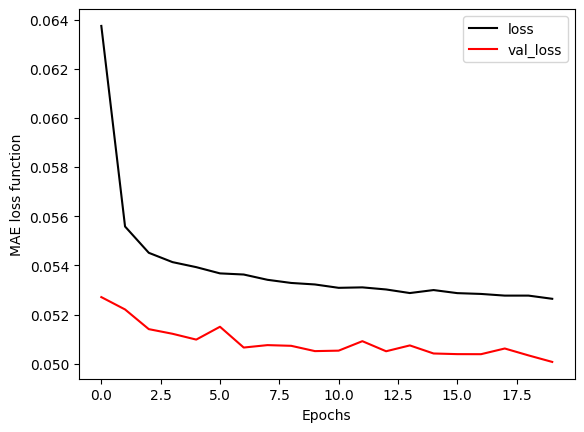

In [ ]:

xlen=len(history.history['loss'])
#high=max((history.history['loss']))
#low=max((history.history['loss']))
#h=high*1.1
#l=low*1.1
plt.plot(range(0,xlen), history.history['loss'], c='k',label='loss')
plt.plot(range(0,xlen), history.history['val_loss'], c='r',label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MAE loss function')
#plt.ylim(l, h)
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import r2_score
y_pred_train_scaled = model.predict(X_train)
y_pred_test_scaled = model.predict(X_test)

X_all_scaled = input_train_scaled
y_pred_all_scaled = model.predict(X_all_scaled)

9945/9945 [==============================] - 16s 2ms/step


In [ ]:
y_pred_train = scaler_targt.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_targt.inverse_transform(y_pred_test_scaled)
y_pred_all = scaler_targt.inverse_transform(y_pred_all_scaled)
Y_train = scaler_targt.inverse_transform(y_train)
Y_test =scaler_targt.inverse_transform(y_test)
y_all = df_copy['GPP'].values

In [ ]:
#print(X_train.shape)
#print(X_test.shape)
#print(y_pred_train.shape)
#print(y_train.shape)
print(r2_score(Y_train,y_pred_train))
#print(y_pred_test.shape)
#print(y_test.shape)
print(r2_score(Y_test,y_pred_test))
#print(X_all.shape)
#print(y_pred_all.shape)
#print(y_all.shape)
print(r2_score(y_all,y_pred_all))


0.6552546495394265
0.6544653704001306
0.6550598906253922


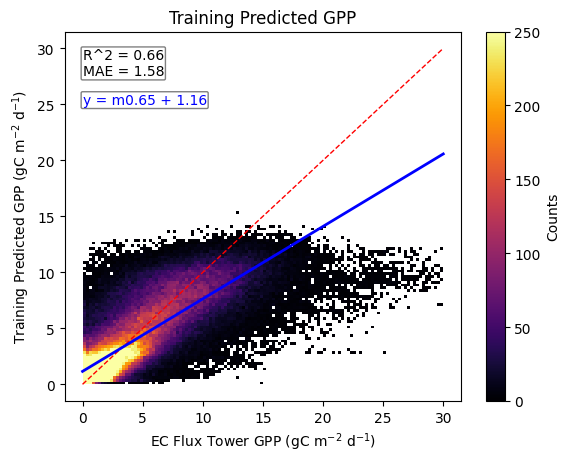

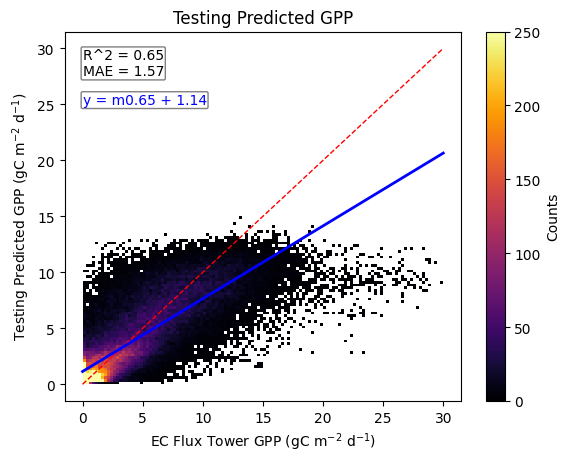

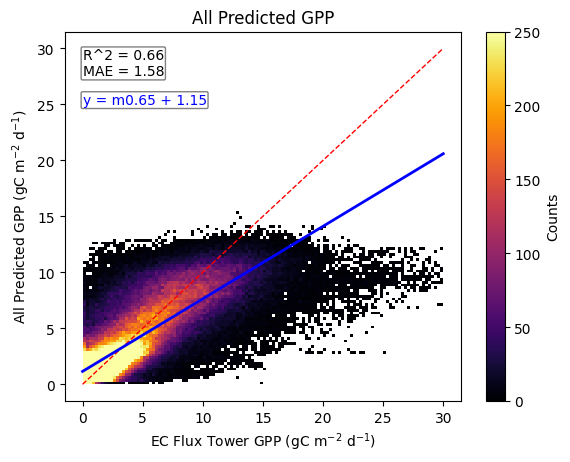

In [ ]:
scatter_plot(np.squeeze(Y_train), np.squeeze(y_pred_train),'Training')
scatter_plot(np.squeeze(Y_test), np.squeeze(y_pred_test),'Testing')
scatter_plot(np.squeeze(y_all), np.squeeze(y_pred_all),'All')

In [ ]:
y_pred_all_save_NoMet = y_pred_all
df_copy['My Y Pred No Met'] = np.squeeze(y_pred_all)
pd.set_option('display.max_columns', None)
display(df_copy.head())

,Year,Month,Day,Name,Type,Latitude,Longitude,NEE_VUT_REF,NEE_VUT_REF_RANDUNC,NEE_VUT_REF_QC,RECO_NT_VUT_REF,RECO_DT_VUT_REF,GPP_NT_VUT_REF,GPP_DT_VUT_REF,TA_F,TA_F_QC,VPD_F,VPD_F_QC,SW_IN_F,SW_IN_F_QC,SW_IN_POT,SW_DIF,PAR_clr,MCD43_B1,MCD43_B2,MCD43_B3,MCD43_B4,MCD43_B5,MCD43_B6,MCD43_B7,MCD43a_B1,MCD43a_B2,MCD43a_B3,MCD43a_B4,MCD43a_B5,MCD43a_B6,MCD43a_B7,Date,GPP FSv2.0,GPP FSv2.2,GPP,My Y Pred No Met
0,2009,12,21,AR-SLu,MF,-33.464802,-66.459801,-6.20090,0.382884,0.916667,4.09222,11.6078,14.8904,14.6503,29.247999,0.9375,24.445999,0.937500,343.346008,0.708333,516.968994,NaN,0.362574,0.081,0.235,0.044,0.076,0.287,0.252,0.158,0.0834,0.2336,0.0466,0.0782,0.2861,0.2477,0.1591,2009-12-21,5.068244,4.779741,14.770350,3.688714
1,2009,12,22,AR-SLu,MF,-33.464802,-66.459801,-5.61956,0.372080,0.937500,3.95545,11.8719,14.1744,14.3019,30.527000,1.0000,23.583000,1.000000,324.569000,0.812500,517.068970,NaN,0.362601,0.079,0.237,0.043,0.076,0.289,0.252,0.156,0.0817,0.2362,0.0457,0.0776,0.2883,0.2482,0.1581,2009-12-22,5.117513,4.775973,14.238150,3.825495
2,2009,12,23,AR-SLu,MF,-33.464802,-66.459801,-4.28703,0.334310,0.812500,3.31299,11.6788,11.1678,11.3725,28.902000,1.0000,16.900999,0.979167,220.972000,0.666667,517.125000,NaN,0.362601,0.080,0.240,0.043,0.076,0.291,0.255,0.156,0.0819,0.2398,0.0457,0.0781,0.2927,0.2505,0.1566,2009-12-23,5.025277,4.977170,11.270150,3.861691
3,2009,12,24,AR-SLu,MF,-33.464802,-66.459801,-6.30522,0.443418,1.000000,2.85094,11.1704,14.0823,14.6363,25.225000,1.0000,11.938000,1.000000,333.109009,0.854167,517.137024,NaN,0.362574,0.080,0.240,0.043,0.075,0.291,0.256,0.155,0.0816,0.2400,0.0456,0.0778,0.2933,0.2528,0.1559,2009-12-24,5.130382,5.044286,14.359301,3.864476
4,2009,12,25,AR-SLu,MF,-33.464802,-66.459801,-3.96959,0.401757,0.833333,3.39763,10.3867,13.9436,14.0756,28.948000,1.0000,18.299999,1.000000,335.119995,0.770833,517.104980,NaN,0.362522,0.075,0.230,0.040,0.071,0.279,0.241,0.151,0.0744,0.2290,0.0402,0.0711,0.2831,0.2339,0.1507,2009-12-25,5.025183,4.982818,14.009600,4.079983


In [ ]:
# Do analysis over again but include Temp and VPD as input features for 1st hidden layer.
#Some data processing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
X=[]
y=[]
df_feature=[]
features = ['Name','GPP', 'PAR_clr','MCD43_B1','MCD43_B2','MCD43_B3','MCD43_B4','MCD43_B5','MCD43_B6','MCD43_B7','TA_F','VPD_F'] #features to use for NN
df_features = df_copy[features]
input = ['PAR_clr','MCD43_B1','MCD43_B2','MCD43_B3','MCD43_B4','MCD43_B5','MCD43_B6','MCD43_B7','TA_F','VPD_F'] #input features

#"shrinking" my dataset her so I can more quickly determine hyperparameters to use
#using keras tuner. Ideally I'd use the whole dataset once I'm happy how the tuner is set up.
df_copy_small = df_copy.sample(frac=0.05, random_state=11)

X = df_copy_small[input].values #input
y = df_copy_small['GPP'].values #label

#print(X.shape)
#print(y.shape)

# create our scaler object
scaler_input = MinMaxScaler() #tried MinMaxScaler and did not like, StandardScaler was worse
scaler_targt = MinMaxScaler() #PowerTransformer was even worse!!!
# fit it to our training set
scaler_input.fit(X)
scaler_targt.fit(np.reshape(y, (-1,1)))
# now transform our input data and labels
input_train_scaled = scaler_input.transform(X)
label_train_scaled = scaler_targt.fit_transform(np.reshape(y, (-1,1)))
#y=np.reshape(y, (-1,1))

#print(y)
#print(label_train_scaled)
#I could not figure out how to "unscale" my predicted data quickly, which got put to the end of a "to do" list
#so I am just using the actual values for my predicted label
#I know this is not best practice.
X_train, X_test, y_train, y_test = train_test_split(input_train_scaled, label_train_scaled, test_size=0.25, random_state=11)

#print(type(X_train))
#print(X_train.shape)

# Make X_train and X_test into 2 separate inputs for sat. data & ParToa and then T & VPD
X_train_input_lay = X_train[:, :8]
X_train_1sthd_lay = X_train[:, -2:]
X_test_input_lay = X_test[:, :8]
X_test_1sthd_lay = X_test[:, -2:]

print(X_train_input_lay.shape)
print(X_train_1sthd_lay.shape)
print(X_test_input_lay.shape)
print(X_test_1sthd_lay.shape)
print(X_train)
print(X_train_input_lay)
print(X_train_1sthd_lay)

(11933, 8)
(11933, 2)
(3978, 8)
(3978, 2)
[[0.6709137  0.030837   0.38344988 ... 0.12678936 0.76353633 0.14616689]
 [0.8680861  0.21696037 0.3205128  ... 0.6993865  0.7690662  0.19655988]
 [0.8648915  0.06497797 0.20396271 ... 0.22085889 0.7262481  0.23593423]
 ...
 [0.61873794 0.030837   0.3030303  ... 0.10838445 0.73290366 0.11527585]
 [0.67199016 0.02092511 0.26107225 ... 0.07361963 0.65632915 0.07629152]
 [0.2833625  0.08810572 0.1993007  ... 0.36196315 0.50265944 0.02457242]]
[[0.6709137  0.030837   0.38344988 ... 0.5387388  0.25675678 0.12678936]
 [0.8680861  0.21696037 0.3205128  ... 0.6198198  0.6452703  0.6993865 ]
 [0.8648915  0.06497797 0.20396271 ... 0.38738742 0.32094598 0.22085889]
 ...
 [0.61873794 0.030837   0.3030303  ... 0.4828829  0.23986487 0.10838445]
 [0.67199016 0.02092511 0.26107225 ... 0.3765766  0.16722974 0.07361963]
 [0.2833625  0.08810572 0.1993007  ... 0.4828829  0.43750003 0.36196315]]
[[0.76353633 0.14616689]
 [0.7690662  0.19655988]
 [0.7262481  0.23593

In [ ]:
#define model to use in keras tuner with set number of layers
#BUT ADD more input features for Temp and VPD in hidden layer after input layer
#apparently I can not use keras.Sequential() for this and have to use functional API?

from keras.layers import Dense, Dropout
from kerastuner import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

#activation functions for each layer used above
#selu relu softsign
#these could change probably when using the above tuner

def build_model(hp):
    # Define the first input feature and secon input feature for first hidden layer
    input1 = keras.Input(shape=(8,), name="input_layer")
    input2 = keras.Input(shape=(2,), name="input_feature2")

    # Define the number of neurons for the first and second hidden layer (hyperparameter)
    hp_units_1 = hp.Int('units_1', min_value=2, max_value=32, step=2)
    hp_units_2 = hp.Int('units_2', min_value=2, max_value=32, step=2)

    # Define the first hidden layer
    hidden1 = layers.Dense(units=hp_units_1, activation='selu')(input1)

    # Concatenate the output of the first hidden layer with the second input feature
    concatenated = layers.concatenate([hidden1, input2])
    #Additional Hidden layer
    hidden2 = layers.Dense(units=hp_units_2, activation='relu')(concatenated)

    # Output layer
    output = layers.Dense(1, activation='softsign')(hidden2)

    # Define the model
    model = keras.Model(inputs=[input1, input2], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='mae')

    return model


'\n    # input layer stays the same as before\n    model.add(input1)\n    #model.add(keras.Input(shape=(8,), name="input_layer"))\n\n    # instead of choosing the number of nodes, we add an hp object\n    hp_units_1 = hp.Int(\'units_1\', min_value=2, max_value=32, step=2)\n    hp_units_2 = hp.Int(\'units_2\', min_value=2, max_value=32, step=2)\n\n    #1st hidden layer, also learning activation function, and dropout rate\n    hidden1=model.add(\n        keras.layers.Dense(\n            units=hp_units_1,\n            #activation=keras.activations.softsign #softsign\n            activation=hp.Choice("activation_1", ["relu", "tanh","selu","sigmoid","relu6","silu","gelu","softsign","sigmoid","linear","softmax"]),\n            )\n        )\n    concatenated = layers.concatenate([hidden1, input2])\n    model.add(keras.layers.Dropout(rate=hp.Float(\'dropout_rate_1\', min_value=0.0, max_value=0.5, step=0.1)))\n    \n    #2nd hidden layer, also learning activation function, and dropout rate\n   

In [ ]:
tuner.search_space_summary()
# Initialize the tuner

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_loss",direction="min"),
    max_trials=5,
    #num_initial_points=1000, #"If left unspecified, a value of 3 times the dimensionality of the hyperparameter space is used."
    alpha=0.0001, #Float, the value added to the diagonal of the kernel matrix during fitting. It represents the expected amount of noise in the observed performances in Bayesian optimization. Defaults to 1e-4.
    beta=2.6*2, #Float, the balancing factor of exploration and exploitation. The larger it is, the more explorative it is. Defaults to 2.6.
    seed=123,
    # hyperparameters=None, #Optional HyperParameters instance. Can be used to override (or register in advance) hyperparameters in the search space.
    tune_new_entries=True,  #Boolean, whether hyperparameter entries that are requested by the hypermodel but that were not specified in hyperparameters should be added to the search space, or not. If not, then the default value for these parameters will be used. Defaults to True.
    allow_new_entries=True, #Boolean, whether the hypermodel is allowed to request hyperparameter entries not listed in hyperparameters. Defaults to True.
    max_retries_per_trial=0,  #Integer. Defaults to 0. The maximum number of times to retry a Trial if the trial crashed or the results are invalid.
    max_consecutive_failed_trials=3,  #Integer. Defaults to 3. The maximum number of consecutive failed Trials. When this number is reached, the search will be stopped. A Trial is marked as failed when none of the retries succeeded.
    overwrite=True
)

#tuner = RandomSearch(
#    build_model,
#    objective='val_accuracy',
#    max_trials=5,
#    executions_per_trial=3,
#    directory='my_dir',
#    project_name='my_project'
#)

#I haven't figured out how to search multiple other hyperparameters using Functional API like i did when using .Sequntial()
#I'm using the same fitting functions I used above


Search space summary
Default search space size: 2
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 2, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 32, 'step': 2, 'sampling': 'linear'}


In [ ]:

tuner.search(x=[X_train_input_lay, X_train_1sthd_lay],
             y=y_train,
             epochs=10,
             validation_data=([X_test_input_lay, X_test_1sthd_lay], y_test))


In [ ]:
models = tuner.get_best_models(num_models=5)
models

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 16)                   144       ['input_layer[0][0]']         
                                                                                                  
 input_feature2 (InputLayer  [(None, 2)]                  0         []                            
 )                                                                                                
                                                                                                  
 concatenate (Concatenate)   (None, 18)                   0         ['dense[0][0]',           

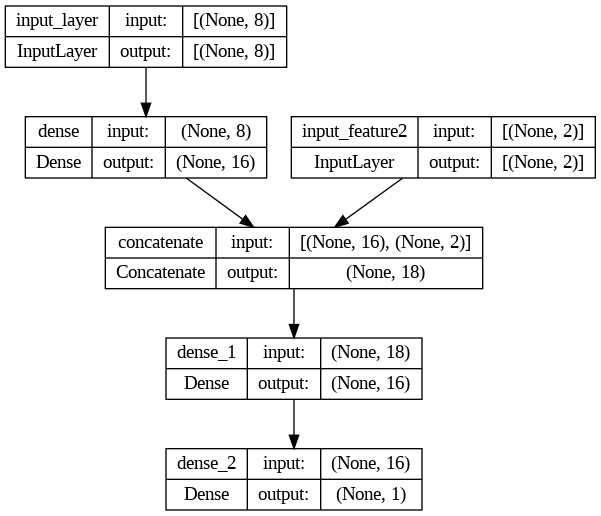

In [ ]:
# here is the best model
import tensorflow as tf

best_model = models[0]
best_model.summary()
tf.keras.utils.plot_model(best_model,to_file='simple.png',show_shapes=True)

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
units_1: 16
units_2: 16
Score: 0.05074261873960495

Trial 3 summary
Hyperparameters:
units_1: 12
units_2: 14
Score: 0.050852447748184204

Trial 1 summary
Hyperparameters:
units_1: 30
units_2: 20
Score: 0.05100472643971443

Trial 2 summary
Hyperparameters:
units_1: 20
units_2: 18
Score: 0.05119326710700989

Trial 0 summary
Hyperparameters:
units_1: 2
units_2: 32
Score: 0.051344133913517


In [ ]:
# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=3)
best_hps

In [ ]:
# Build the model with the best hp.
model = build_model(best_hps[0])
model.save('my_tuned_model_Met.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Run saved model from tuner on full dataset instead of reduced sized dataset

X = df_copy[input].values
y = df_copy['GPP'].values

# create our scaler object
scaler_input = MinMaxScaler() #tried StandardScaler, MinMaxScaler, PowerTransformer, and QuantileTransformer
scaler_targt = MinMaxScaler()
# fit it to our training set
scaler_input.fit(X)
scaler_targt.fit(np.reshape(y, (-1,1)))
# now transform our input data and labels
input_train_scaled = scaler_input.transform(X)
label_train_scaled = scaler_targt.fit_transform(np.reshape(y, (-1,1)))
y=np.reshape(y, (-1,1))

#print(y)
#print(label_train_scaled)

X_train, X_test, y_train, y_test = train_test_split(input_train_scaled, label_train_scaled, test_size=0.25, random_state=11)

X_train_input_lay = X_train[:, :8]
X_train_1sthd_lay = X_train[:, -2:]
X_test_input_lay = X_test[:, :8]
X_test_1sthd_lay = X_test[:, -2:]

print(X_train_input_lay.shape)
print(X_train_1sthd_lay.shape)
print(X_test_input_lay.shape)
print(X_test_1sthd_lay.shape)


es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

x=[X_train_input_lay, X_train_1sthd_lay]
vd=([X_test_input_lay, X_test_1sthd_lay], y_test)

history = model.fit(
    x,
    y_train,
    epochs=20,
    validation_data=vd,
    batch_size=256,
    callbacks=[es]#, managed to get early stopping in here, not sure hot to do kfold cross validation
    #folds=kf
    )

(238671, 8)
(238671, 2)
(79558, 8)
(79558, 2)
Epoch 1/20
933/933 [==============================] - 9s 9ms/step - loss: 0.0559 - val_loss: 0.0513
Epoch 2/20
933/933 [==============================] - 5s 5ms/step - loss: 0.0510 - val_loss: 0.0507
Epoch 3/20
933/933 [==============================] - 5s 5ms/step - loss: 0.0501 - val_loss: 0.0494
Epoch 4/20
933/933 [==============================] - 6s 7ms/step - loss: 0.0497 - val_loss: 0.0492
Epoch 5/20
933/933 [==============================] - 4s 5ms/step - loss: 0.0494 - val_loss: 0.0490
Epoch 6/20
933/933 [==============================] - 4s 4ms/step - loss: 0.0492 - val_loss: 0.0491
Epoch 7/20
933/933 [==============================] - 5s 5ms/step - loss: 0.0491 - val_loss: 0.0487
Epoch 8/20
933/933 [==============================] - 5s 6ms/step - loss: 0.0490 - val_loss: 0.0487
Epoch 9/20
933/933 [==============================] - 6s 6ms/step - loss: 0.0489 - val_loss: 0.0486
Epoch 10/20
933/933 [==============================] -

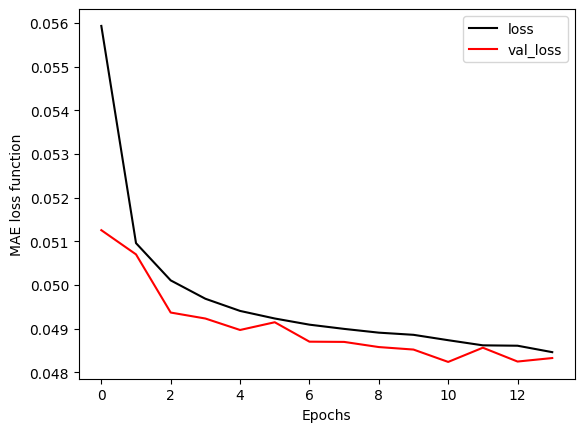

In [ ]:
xlen=len(history.history['loss'])
#high=max((history.history['loss']))
#low=max((history.history['loss']))
#h=high*1.1
#l=low*1.1
plt.plot(range(0,xlen), history.history['loss'], c='k',label='loss')
plt.plot(range(0,xlen), history.history['val_loss'], c='r',label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MAE loss function')
#plt.ylim(l, h)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
y_pred_train_scaled = model.predict(x)
#y_pred_test_scaled = model.predict(vd) getting error from this? gonna comment out cuz I don't need the testing data alone

X_all_scaled_input_lay = input_train_scaled[:, :8]
X_all_scaled_1sthd_lay = input_train_scaled[:, -2:]

X_all_scaled = input_train_scaled
y_pred_all_scaled = model.predict([X_all_scaled_input_lay,X_all_scaled_1sthd_lay])

9945/9945 [==============================] - 54s 5ms/step


In [ ]:
y_pred_train = scaler_targt.inverse_transform(y_pred_train_scaled)
#y_pred_test = scaler_targt.inverse_transform(y_pred_test_scaled)
y_pred_all = scaler_targt.inverse_transform(y_pred_all_scaled)
Y_train = scaler_targt.inverse_transform(y_train)
#Y_test =scaler_targt.inverse_transform(y_test)
y_all = df_copy['GPP'].values

In [ ]:
#print(X_train.shape)
#print(X_test.shape)
#print(y_pred_train.shape)
#print(y_train.shape)
print(r2_score(Y_train,y_pred_train))
#print(y_pred_test.shape)
#print(y_test.shape)
#print(r2_score(Y_test,y_pred_test))
#print(X_all.shape)
#print(y_pred_all.shape)
#print(y_all.shape)
print(r2_score(y_all,y_pred_all))

0.6768785429570929
0.6768326414832886


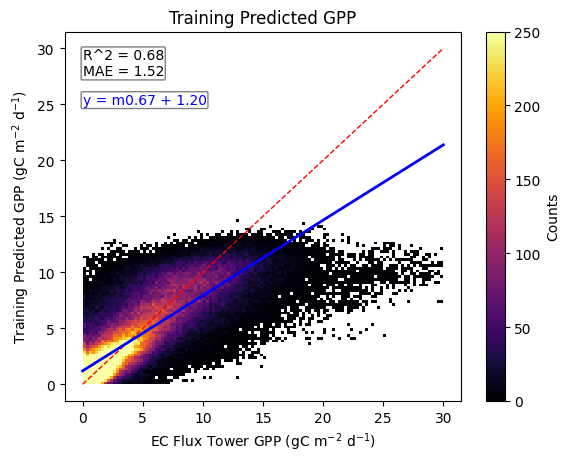

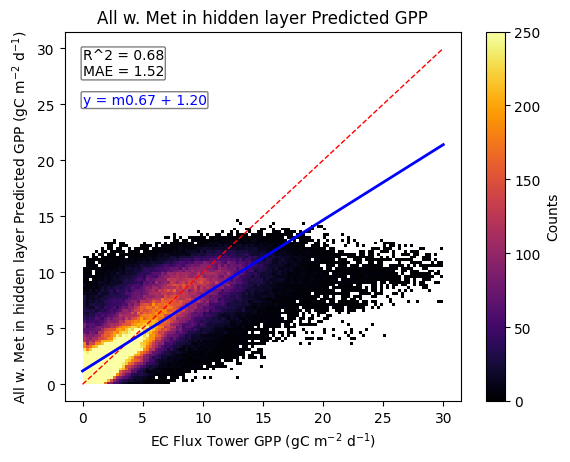

In [ ]:
scatter_plot(np.squeeze(Y_train), np.squeeze(y_pred_train),'Training')
#scatter_plot(np.squeeze(Y_test), np.squeeze(y_pred_test),'Testing')
scatter_plot(np.squeeze(y_all), np.squeeze(y_pred_all),'All w. Met in hidden layer')

In [ ]:
y_pred_all_save_YesMet = y_pred_all
df_copy['My Y Pred Yes Met'] = np.squeeze(y_pred_all)
pd.set_option('display.max_columns', None)
display(df_copy.head())

,Year,Month,Day,Name,Type,Latitude,Longitude,NEE_VUT_REF,NEE_VUT_REF_RANDUNC,NEE_VUT_REF_QC,RECO_NT_VUT_REF,RECO_DT_VUT_REF,GPP_NT_VUT_REF,GPP_DT_VUT_REF,TA_F,TA_F_QC,VPD_F,VPD_F_QC,SW_IN_F,SW_IN_F_QC,SW_IN_POT,SW_DIF,PAR_clr,MCD43_B1,MCD43_B2,MCD43_B3,MCD43_B4,MCD43_B5,MCD43_B6,MCD43_B7,MCD43a_B1,MCD43a_B2,MCD43a_B3,MCD43a_B4,MCD43a_B5,MCD43a_B6,MCD43a_B7,Date,GPP FSv2.0,GPP FSv2.2,GPP,My Y Pred Yes Met
0,2009,12,21,AR-SLu,MF,-33.464802,-66.459801,-6.20090,0.382884,0.916667,4.09222,11.6078,14.8904,14.6503,29.247999,0.9375,24.445999,0.937500,343.346008,0.708333,516.968994,NaN,0.362574,0.081,0.235,0.044,0.076,0.287,0.252,0.158,0.0834,0.2336,0.0466,0.0782,0.2861,0.2477,0.1591,2009-12-21,5.068244,4.779741,14.770350,3.607624
1,2009,12,22,AR-SLu,MF,-33.464802,-66.459801,-5.61956,0.372080,0.937500,3.95545,11.8719,14.1744,14.3019,30.527000,1.0000,23.583000,1.000000,324.569000,0.812500,517.068970,NaN,0.362601,0.079,0.237,0.043,0.076,0.289,0.252,0.156,0.0817,0.2362,0.0457,0.0776,0.2883,0.2482,0.1581,2009-12-22,5.117513,4.775973,14.238150,3.882804
2,2009,12,23,AR-SLu,MF,-33.464802,-66.459801,-4.28703,0.334310,0.812500,3.31299,11.6788,11.1678,11.3725,28.902000,1.0000,16.900999,0.979167,220.972000,0.666667,517.125000,NaN,0.362601,0.080,0.240,0.043,0.076,0.291,0.255,0.156,0.0819,0.2398,0.0457,0.0781,0.2927,0.2505,0.1566,2009-12-23,5.025277,4.977170,11.270150,4.295226
3,2009,12,24,AR-SLu,MF,-33.464802,-66.459801,-6.30522,0.443418,1.000000,2.85094,11.1704,14.0823,14.6363,25.225000,1.0000,11.938000,1.000000,333.109009,0.854167,517.137024,NaN,0.362574,0.080,0.240,0.043,0.075,0.291,0.256,0.155,0.0816,0.2400,0.0456,0.0778,0.2933,0.2528,0.1559,2009-12-24,5.130382,5.044286,14.359301,4.276761
4,2009,12,25,AR-SLu,MF,-33.464802,-66.459801,-3.96959,0.401757,0.833333,3.39763,10.3867,13.9436,14.0756,28.948000,1.0000,18.299999,1.000000,335.119995,0.770833,517.104980,NaN,0.362522,0.075,0.230,0.040,0.071,0.279,0.241,0.151,0.0744,0.2290,0.0402,0.0711,0.2831,0.2339,0.1507,2009-12-25,5.025183,4.982818,14.009600,4.356023


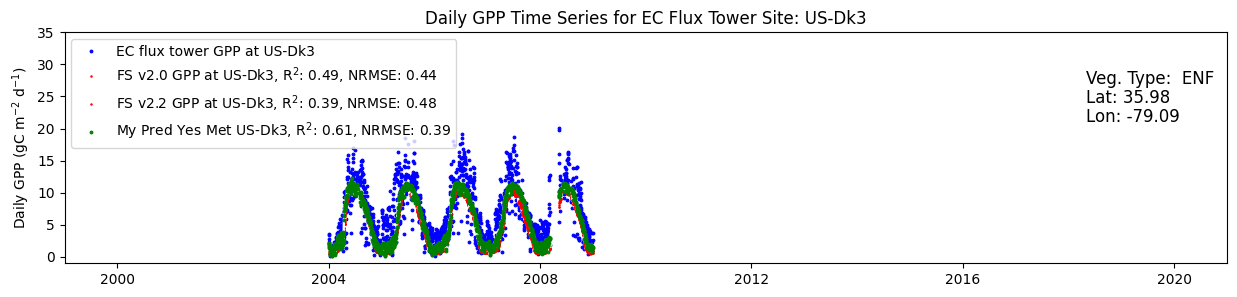

In [ ]:
#Plot a single site with my predictions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
unique_name = 'US-Dk3'  #I used BR-Sa1, CA-TP4, DE-Geb, US-Dk3
fig, ax = plt.subplots(figsize=(15,3))
filtered_df = df_copy[df_copy['Name'] == unique_name]
r2FSv20 = r2_score(filtered_df['GPP'].values,filtered_df['GPP FSv2.0'].values)
r2FSv22 = r2_score(filtered_df['GPP'].values,filtered_df['GPP FSv2.2'].values)
r2NoMet = r2_score(filtered_df['GPP'].values,filtered_df['My Y Pred Yes Met'].values)
rmseFSv20 = np.sqrt(mean_squared_error(filtered_df['GPP'].values,filtered_df['GPP FSv2.0'].values))
rmseFSv22 = np.sqrt(mean_squared_error(filtered_df['GPP'].values,filtered_df['GPP FSv2.2'].values))
rmseNoMet = np.sqrt(mean_squared_error(filtered_df['GPP'].values,filtered_df['My Y Pred Yes Met'].values))
meanGPP = filtered_df['GPP'].mean()
nrmseFSv20 = rmseFSv20/meanGPP
nrmseFSv22 = rmseFSv22/meanGPP
nrmseNoMet = rmseNoMet/meanGPP
sns.lineplot(x = 'Date', y = 'GPP',data = filtered_df, marker='o', color='white', markerfacecolor='blue', markeredgecolor='blue', markersize=2, label='EC flux tower GPP at ' + unique_name)
sns.lineplot(x = 'Date', y = 'GPP FSv2.0',data = filtered_df, marker='o', color='white', markerfacecolor='red', markeredgecolor='red', markersize=1, label='FS v2.0 GPP at ' + unique_name + ', R$\mathregular{^{2}}$: ' + str(format(r2FSv20, ".2f")) + ', NRMSE: ' + str(format(nrmseFSv20, ".2f")))
sns.lineplot(x = 'Date', y = 'GPP FSv2.2',data = filtered_df, marker='o', color='white', markerfacecolor='red', markeredgecolor='red', markersize=1, label='FS v2.2 GPP at ' + unique_name + ', R$\mathregular{^{2}}$: ' + str(format(r2FSv22, ".2f")) + ', NRMSE: ' + str(format(nrmseFSv22, ".2f")))
sns.lineplot(x = 'Date', y = 'My Y Pred Yes Met',data = filtered_df, marker='o', color='white', markerfacecolor='green', markeredgecolor='green', markersize=2, label='My Pred Yes Met ' + unique_name + ', R$\mathregular{^{2}}$: ' + str(format(r2NoMet, ".2f")) + ', NRMSE: ' + str(format(nrmseNoMet, ".2f")))
ylim = [-1, 35]
ax.set_ylim(ylim)
ax.set_xlim([datetime.date(1999, 1, 1), datetime.date(2020, 12, 31)])
lat = filtered_df.iloc[0]['Latitude']
lon = filtered_df.iloc[0]['Longitude']
veg = filtered_df.iloc[0]['Type']
ax.text(datetime.date(2018, 5, 1), 27, 'Veg. Type: ' + veg, fontsize=12, color='black')
ax.text(datetime.date(2018, 5, 1), 24, 'Lat: ' + str(format(lat, ".2f")), fontsize=12, color='black')
ax.text(datetime.date(2018, 5, 1), 21, 'Lon: ' + str(format(lon, ".2f")), fontsize=12, color='black')
plt.title(f"Daily GPP Time Series for EC Flux Tower Site: {unique_name}")
plt.xlabel('')
ax.set_ylabel(r'Daily GPP (gC m$\mathregular{^{-2}}$ d$\mathregular{^{-1}}$)',
               fontsize=10)

plt.legend(loc='upper left')
plt.show()